In [1]:
import sys
sys.path.append("../classes")

In [2]:
import pickle
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest
from sklearn.manifold import TSNE, Isomap, MDS, SpectralEmbedding
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

import numpy as np, pandas as pd
from geno_classifier import *
from itertools import starmap, product

import GEOparse

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

### Clustering on diff values

In [3]:
change_lable = lambda label, prefix: '{}_{}'.format(prefix, label)

### breast-cancer

In [4]:
bc_results = pickle.load(open('../results/breast_cancer_2.results','rb'))
bc_labels_ = pickle.load(open('../datasets/breast_cancer_2_y','rb'))

breast_cancer, breast_cancer_labels = preprocess_results(bc_results, bc_labels_, 
                                                         use_diff_score=True, use_pathways=True, 
                                                         scale=False, use_one_hot=False)

breast_cancer.index = starmap(change_lable, product(bc_labels_, ['bc']))

In [5]:
len(list(starmap(change_lable, product(bc_labels_, 'bc'))))

176

In [6]:
breast_cancer[breast_cancer.columns[:5]].head()

,,Alanine and aspartate metabolism,Alkaloid synthesis,Aminosugar metabolism,Androgen and estrogen synthesis and metabolism
bc_unhealthy,-25.490606,-100.777030,7.129360e-06,-55.414072,0.000007
bc_unhealthy,-21.389085,96.445184,-1.006312e-06,73.618178,-0.000001
bc_unhealthy,-29.843938,38.294390,-1.006312e-06,256.413877,-0.000001
bc_healthy,-14.526884,-100.777037,5.131799e-07,-44.661390,0.000002
bc_unhealthy,-12.184960,6.018669,5.672039e-06,-55.414075,0.000006


### lung-cancer

In [7]:
lc_results = pickle.load(open('../results/lung_cancer_1.results','rb'))
lc_labels_ = pickle.load(open('../datasets/lung_cancer_1_y','rb'))

lung_cancer, lung_cancer_y = preprocess_results(lc_results, lc_labels_, 
                                                use_diff_score=True, use_pathways=True, 
                                                scale=False, use_one_hot=False)

lung_cancer.index = starmap(change_lable, product(lc_labels_, ['lg']))

In [8]:
lung_cancer[lung_cancer.columns[:5]].head()

,,Alanine and aspartate metabolism,Alkaloid synthesis,Aminosugar metabolism,Androgen and estrogen synthesis and metabolism
lg_unhealthy,48.843000,138.648466,-0.000006,-82.204632,-0.000011
lg_unhealthy,2.642386,138.648466,-0.000006,-82.204632,-0.000011
lg_unhealthy,41.381614,-4.367172,-0.000006,-82.204632,-0.000011
lg_unhealthy,-3.062908,109.866720,-0.000005,-114.462695,-0.000009
lg_unhealthy,89.662783,138.648466,-0.000006,-103.710008,-0.000011


### diseases combined

In [9]:
classes = {'bc_unhealthy': 0, 'bc_healthy': 1, 'lg_unhealthy': 2, 'lg_healthy': 3}

In [10]:
diseases = pd.concat([breast_cancer, lung_cancer])
reduced_diseases = PCA(n_components=2).fit_transform(diseases)

y = [classes[i] for i in np.array(diseases.index)]

In [11]:
kmeans = KMeans(n_clusters=5, random_state=42).fit(reduced_diseases)

### healthy grey, bc magenta, lg pink

In [12]:
colors = {0 : 'darkmagenta', 1 : 'lightpink', 2 : 'grey', 3:'lightblue'}

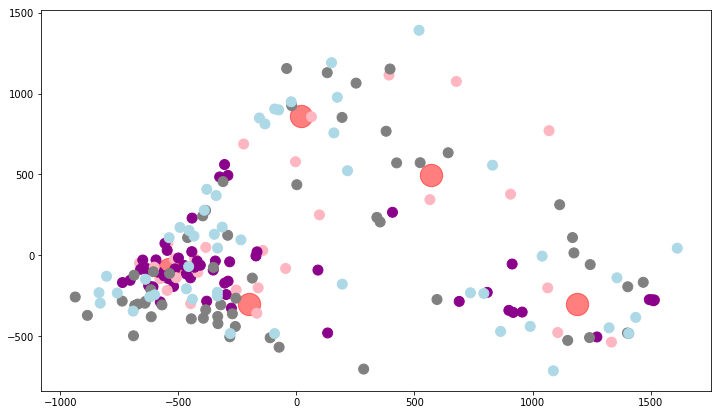

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 7))

centers = kmeans.cluster_centers_

plt.scatter(centers[:, 0], centers[:, 1], c='red', alpha=0.5, s=500)
plt.scatter(reduced_diseases[:, 0], reduced_diseases[:, 1], c=[colors[i] for i in y], s=100)

In [14]:
from sklearn.metrics import homogeneity_completeness_v_measure

In [15]:
homogeneity_completeness_v_measure(y, kmeans.labels_)

(0.03866296312148667, 0.03670325192308999, 0.037657628811576575)

## t-SNE

In [16]:
diseases_reduced_tsne = TSNE(n_components=2, random_state=42).fit_transform(diseases)

In [17]:
kmeans_tsne = KMeans(n_clusters=5, random_state=42).fit(diseases_reduced_tsne)

In [18]:
homogeneity_completeness_v_measure(y, kmeans_tsne.labels_)

(0.06543326209065642, 0.05556486131930692, 0.06009663672912476)

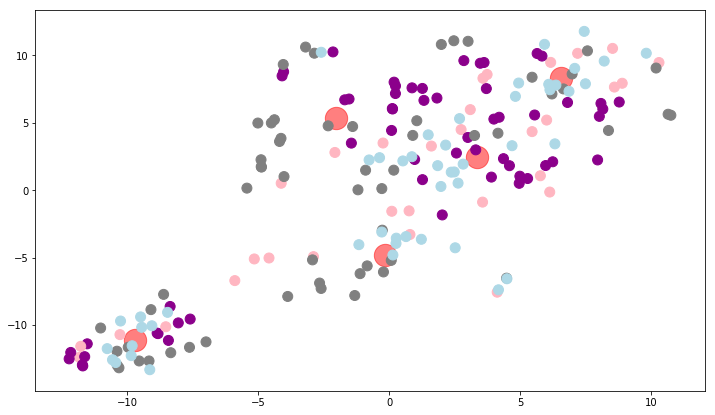

In [19]:
plt.figure(figsize=(12, 7))

centers = kmeans_tsne.cluster_centers_

plt.scatter(centers[:, 0], centers[:, 1], c='red', alpha=0.5, s=500)
plt.scatter(diseases_reduced_tsne[:, 0], diseases_reduced_tsne[:, 1], c=[colors[i] for i in y], s=100)

## LDA

In [20]:
diseases_reduced_lda = LinearDiscriminantAnalysis(n_components=2).fit_transform(diseases, y)

/usr/local/lib/python3.5/dist-packages/sklearn/discriminant_analysis.py:388 UserWarning: Variables are collinear.


In [21]:
kmeans_lda = KMeans(n_clusters=5, random_state=42).fit(diseases_reduced_lda)

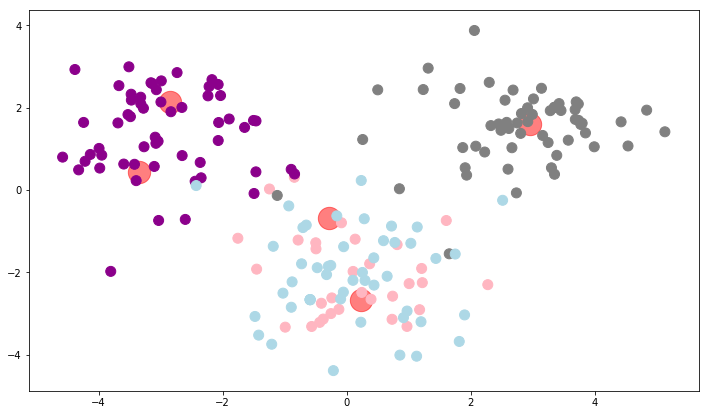

In [22]:
plt.figure(figsize=(12, 7))

centers = kmeans_lda.cluster_centers_

plt.scatter(centers[:, 0], centers[:, 1], c='red', alpha=0.5, s=500)
plt.scatter(diseases_reduced_lda[:, 0], diseases_reduced_lda[:, 1], c=[colors[i] for i in y], s=100)

## K-best

In [23]:
diseases_reduced_kbest = SelectKBest(k=2).fit_transform(diseases, y)

In [24]:
kmeans_kbest = KMeans(n_clusters=5, random_state=42).fit(diseases)

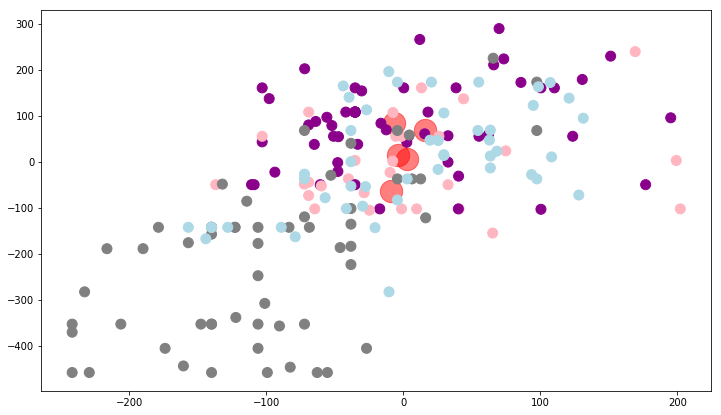

In [25]:
plt.figure(figsize=(12, 7))

centers = kmeans_kbest.cluster_centers_

plt.scatter(centers[:, 0], centers[:, 1], c='red', alpha=0.5, s=500)
plt.scatter(diseases_reduced_kbest[:, 0], diseases_reduced_kbest[:, 1], c=[colors[i] for i in y], s=100)

## Hierarchical clustering

In [26]:
from scipy.cluster import hierarchy

In [27]:
labels_ = list(diseases.iterrows())
labels = dict()
for i in range(len(labels_)):
    labels[i] = labels_[i][0]
labels = np.array(list(labels.items()))

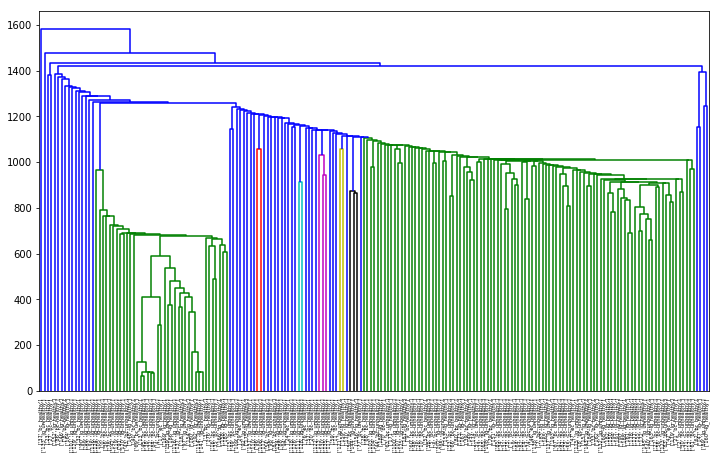

In [28]:
Z = hierarchy.linkage(diseases, method='single')
plt.figure(figsize=(12, 7))
dn = hierarchy.dendrogram(Z, labels=labels)
plt.savefig("hclustering-diff")

# Using no Pathways or Diff Values

In [29]:
breast_cancer, breast_cancer_labels = preprocess_results(bc_results, bc_labels_, 
                                                         use_diff_score=False, use_pathways=False, 
                                                         scale=False, use_one_hot=False)

breast_cancer.index = starmap(change_lable, product(bc_labels_, ['bc']))

lung_cancer, lung_cancer_y = preprocess_results(lc_results, lc_labels_, 
                                                use_diff_score=False, use_pathways=False, 
                                                scale=False, use_one_hot=False)

lung_cancer.index = starmap(change_lable, product(lc_labels_, ['lg']))

## PCA

In [30]:
diseases = pd.concat([breast_cancer, lung_cancer])
reduced_diseases = PCA(n_components=2).fit_transform(diseases)

y = [classes[i] for i in np.array(diseases.index)]
kmeans = KMeans(n_clusters=5, random_state=42).fit(reduced_diseases)
homogeneity_completeness_v_measure(y, kmeans.labels_)

(0.20784790001955392, 0.1792303190012604, 0.1924812277915516)

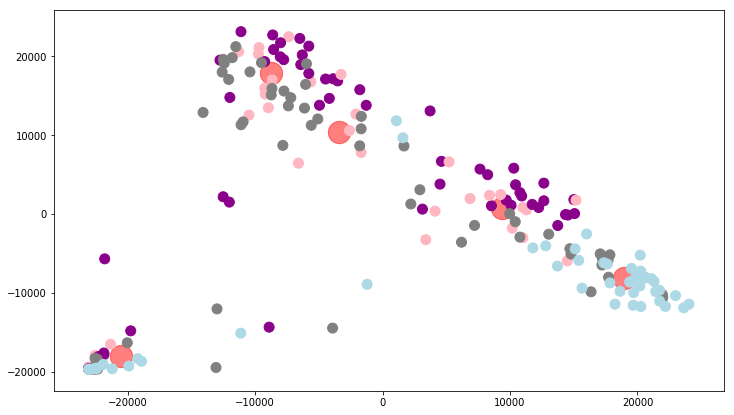

In [31]:
plt.figure(figsize=(12, 7))

centers = kmeans.cluster_centers_

plt.scatter(centers[:, 0], centers[:, 1], c='red', alpha=0.5, s=500)
plt.scatter(reduced_diseases[:, 0], reduced_diseases[:, 1], c=[colors[i] for i in y], s=100)

## t-SNE

In [32]:
diseases_reduced_tsne = TSNE(n_components=2, random_state=42).fit_transform(diseases)
kmeans_tsne = KMeans(n_clusters=5, random_state=42).fit(diseases_reduced_tsne)
homogeneity_completeness_v_measure(y, kmeans_tsne.labels_)

(0.25079025606871824, 0.21672289744743817, 0.2325153443834357)

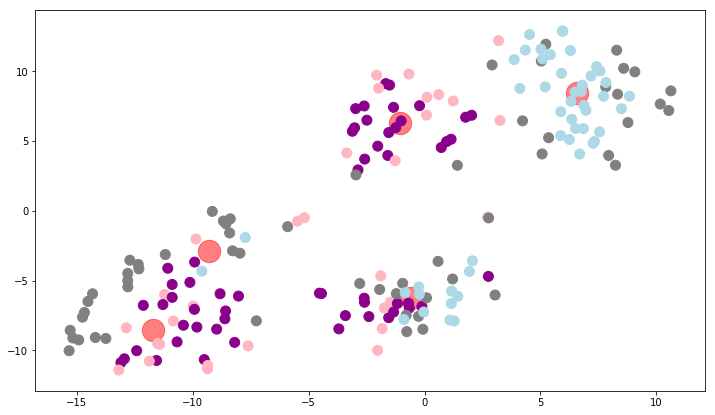

In [33]:
plt.figure(figsize=(12, 7))

centers = kmeans_tsne.cluster_centers_

plt.scatter(centers[:, 0], centers[:, 1], c='red', alpha=0.5, s=500)
plt.scatter(diseases_reduced_tsne[:, 0], diseases_reduced_tsne[:, 1], c=[colors[i] for i in y], s=100)

## H-Clustering

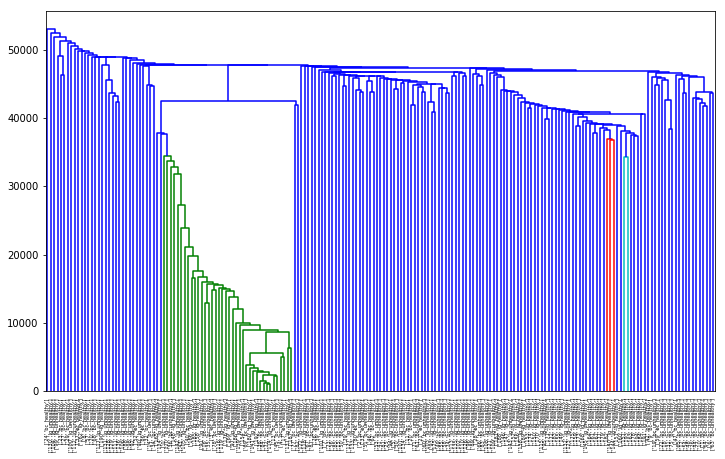

In [34]:
Z = hierarchy.linkage(diseases, method='single')
plt.figure(figsize=(12, 7))
dn = hierarchy.dendrogram(Z, labels=labels)
plt.savefig("hclustering-nodiff")